# Olist : E-commerce Customer Segmentation
## Notebook 3/3: Temporal stability of our model

<b>Notebook description</b> 

In order to confirm that the model stays stable over a certain period of time, we will use the adjusted rand score to measure the point at which our customers' clusters have changed too much. We will train our model on the 2017 data and test the stability on the 2018 data, month by month and then week by week in order to find the precise moment at which our model falls below a certain value.

In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer

from sklearn.pipeline import Pipeline

from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score

# Suppress warnings
import warnings

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("data_rfm.csv")

In [3]:
df = df[
    [
        "order_purchase_timestamp",
        "recency",
        "frequency",
        "monetary",
        "installments",
        "review",
        "month",
    ]
]
df.head(5)

,order_purchase_timestamp,recency,frequency,monetary,installments,review,month
0,2018-05-10 10:56:27,111,1,141.90,8.0,5.0,5.0
1,2018-05-07 11:11:27,114,1,27.19,1.0,4.0,5.0
2,2017-03-10 21:05:03,536,1,86.22,8.0,3.0,3.0
3,2017-10-12 20:29:41,320,1,43.62,4.0,4.0,10.0
4,2017-11-14 19:45:42,287,1,196.89,6.0,5.0,11.0


In [4]:
max_date = pd.to_datetime(df["order_purchase_timestamp"].max())
min_date = pd.to_datetime(df["order_purchase_timestamp"].min())
timespan = (max_date - min_date).days * 0.032855

print("We have data spanning over " + str(timespan) + " months.")

We have data spanning over 22.834225 months.


<AxesSubplot:xlabel='year_month'>

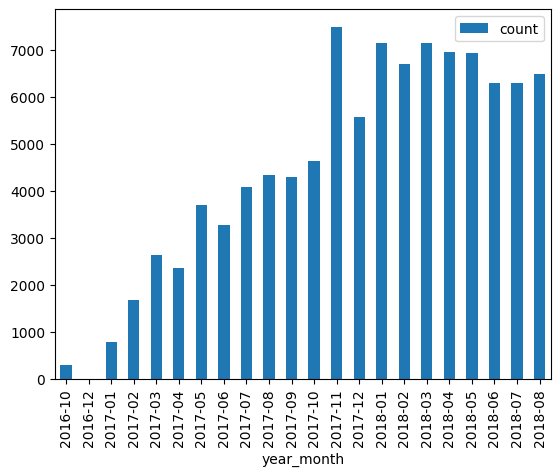

In [5]:
# convert column to datetime
df["order_purchase_timestamp"] = pd.to_datetime(df["order_purchase_timestamp"])

# create a representation of the month with strfmt
df["year_month"] = df["order_purchase_timestamp"].map(lambda dt: dt.strftime("%Y-%m"))

grouped_df = df.groupby("year_month").size().to_frame("count").reset_index()

grouped_df.plot(kind="bar", x="year_month", y="count")

We will train our model on the data from 2017 and check the temporal stability of our model first over the months of 2018 and then over the weeks.

In [6]:
df["week"] = df.order_purchase_timestamp.apply(lambda x: x.weekofyear)
df["year"] = df.order_purchase_timestamp.apply(lambda x: x.year)
df.drop(columns=["order_purchase_timestamp"], inplace=True)

df_2018 = df[df.year == 2018].drop(
    columns=["year", "year_month"]
)  # data only from 2018

### Temporal stability over the months

In [7]:
df_2018 = df[df.year == 2018].drop(
    columns=["year", "year_month", "week"]
)  # data only from 2018

In [18]:
def create_ari_array_months(future_dataframe):

    df_2017 = df[df.year == 2017].drop(
        columns=["year", "year_month", "week"]
    )  # data only from 2017

    df_2017["frequency"] = np.log10(df_2017["frequency"])
    df_2017["monetary"] = np.log10(df_2017["monetary"])
    df_2017_scaler = StandardScaler().fit(df_2017)
    df_2017_scaled = pd.DataFrame(
        df_2017_scaler.transform(df_2017), columns=df_2017.columns
    )

    init_model = KMeans(n_clusters=5, random_state=42)
    init_model.fit(df_2017_scaled)

    ari_array = []
    month = []
    months_in_df = future_dataframe.month.max().astype(int)

    for i in range(1, months_in_df):

        df_current_month = future_dataframe[future_dataframe["month"] <= i]
        df_current_month["frequency"] = np.log10(df_current_month["frequency"])
        df_current_month["monetary"] = np.log10(df_current_month["monetary"])

        df_current_month_scaler = StandardScaler().fit(df_current_month)
        df_current_month_scaled = pd.DataFrame(
            df_current_month_scaler.transform(df_current_month),
            columns=df_current_month.columns,
        )

        model_today = KMeans(n_clusters=5)
        clusters_today = model_today.fit_predict(df_current_month_scaled)

        clusters_today_scaler_2017 = pd.DataFrame(
            df_2017_scaler.transform(df_current_month), columns=df_current_month.columns
        )
        clusters_today_scaler_2017_pred = init_model.predict(clusters_today_scaler_2017)

        ari = adjusted_rand_score(clusters_today_scaler_2017_pred, clusters_today)
        ari_array.append(ari)
        month.append(i)

    ari_df = pd.DataFrame({"month": month, "ARI": ari_array})

    return ari_df

In [19]:
ari_df_months = create_ari_array_months(df_2018)
ari_df_months

,month,ARI
0,1,0.481578
1,2,0.775614
2,3,0.793945
3,4,0.532816
4,5,0.550655
5,6,0.499465
6,7,0.525058
7,8,0.438124
8,9,0.437925
9,10,0.438172


Text(0.5, 1.0, 'ARI score evolution, interval = 1 month')

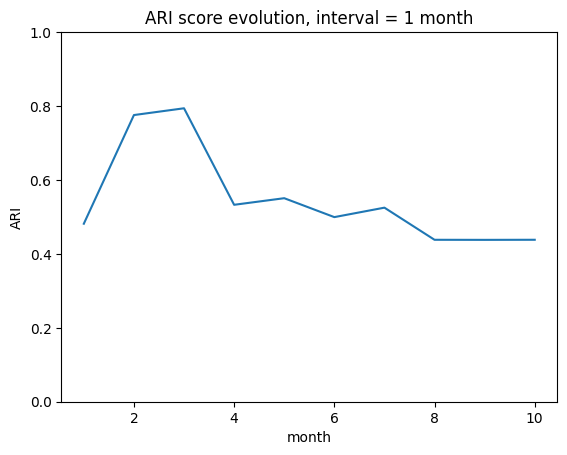

In [20]:
ari_plot = sns.lineplot(data=ari_df_months, x="month", y="ARI")
ari_plot.set_ylim(bottom=0, top=1)
ari_plot.set_title("ARI score evolution, interval = 1 month")

We can see that at approximately 3 months, there is an abrupt fall in the ARI score. This means that the model would need to be retrained at around 3 months in order to avoid false predictions and an inaccurate customer clustering.  

Let's see if we can determine the precise moment when this happens using our function iterated over weeks rather than months.

### Temporal stability over the weeks

In [11]:
df_2018_week = df[df.year == 2018].drop(
    columns=["year", "year_month"]
)  # data only from 2018

In [12]:
def create_ari_array_weeks(future_dataframe):

    df_2017 = df[df.year == 2017].drop(
        columns=["year", "year_month", "week"]
    )  # data only from 2017

    df_2017["frequency"] = np.log10(df_2017["frequency"])
    df_2017["monetary"] = np.log10(df_2017["monetary"])
    df_2017_scaler = StandardScaler().fit(df_2017)
    df_2017_scaled = pd.DataFrame(
        df_2017_scaler.transform(df_2017), columns=df_2017.columns
    )

    init_model = KMeans(n_clusters=5, random_state=42)
    init_model.fit(df_2017_scaled)

    ari_array = []
    week = []
    weeks_in_df = future_dataframe.week.max().astype(int)

    for i in range(1, weeks_in_df):

        df_current_week = future_dataframe[future_dataframe["week"] <= i]
        df_current_week.drop(columns=["week"], inplace=True)

        df_current_week["frequency"] = np.log10(df_current_week["frequency"])
        df_current_week["monetary"] = np.log10(df_current_week["monetary"])

        df_current_week_scaler = StandardScaler().fit(df_current_week)
        df_current_week_scaled = pd.DataFrame(
            df_current_week_scaler.transform(df_current_week),
            columns=df_current_week.columns,
        )

        model_today = KMeans(n_clusters=5)
        clusters_today = model_today.fit_predict(df_current_week_scaled)

        clusters_today_scaler_2017 = pd.DataFrame(
            df_2017_scaler.transform(df_current_week), columns=df_current_week.columns
        )
        clusters_today_scaler_2017_pred = init_model.predict(clusters_today_scaler_2017)

        ari = adjusted_rand_score(clusters_today_scaler_2017_pred, clusters_today)
        ari_array.append(ari)
        week.append(i)

    ari_df = pd.DataFrame({"week": week, "ARI": ari_array})

    return ari_df

In [13]:
ari_df_weeks = create_ari_array_weeks(df_2018_week)
ari_df_weeks

,week,ARI
0,1,0.738616
1,2,0.762719
2,3,0.782074
3,4,0.790059
4,5,0.699201
5,6,0.602255
6,7,0.557990
7,8,0.771625
8,9,0.766095
9,10,0.768901


Text(0.5, 1.0, 'ARI score evolution, interval = 1 week')

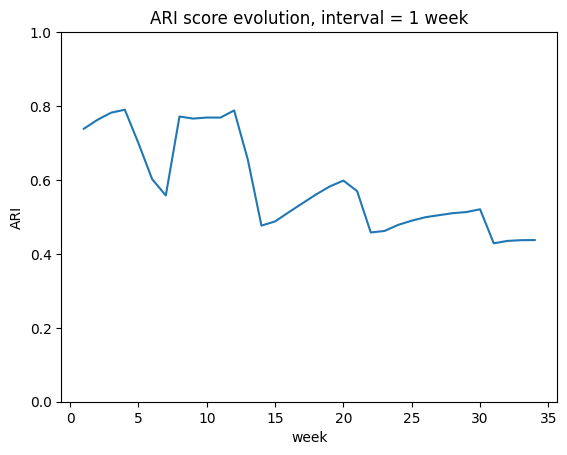

In [14]:
ari_plot = sns.lineplot(data=ari_df_weeks, x="week", y="ARI")
ari_plot.set_ylim(bottom=0, top=1)
ari_plot.set_title("ARI score evolution, interval = 1 week")

Using the dataframe resulting from our function and the line plot, we can tell that at 13 months it will be necessary to retrain the model so that the clustering predictions remain accurate. 